In [79]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [80]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [81]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#use first to use first row

#SQL VERSION #SESSION . QUERY IS SELECT 
#FILTER IS WHERE 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [21]:
# Perform a query to retrieve the data and precipitation scores

# query to pull the last year of precipitation data
rain_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column    order_by(Measurement.date).all()

In [23]:

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_query_df = pd.DataFrame(rain_query)
rain_query_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [25]:
# Sort the dataframe by date
rain_query_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


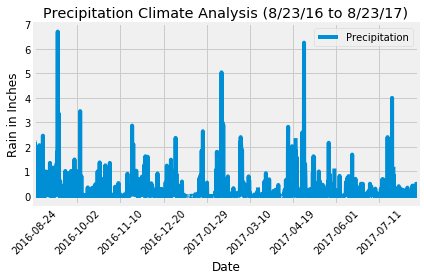

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data

# plotting our dataframe we created 

rain_query_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Climate Analysis (8/23/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_query_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [32]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("{}".format(locations))

9


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_query = session.query(Measurement.station, func.count(Measurement.station))\
        .group_by(Measurement.station)\
        .order_by(func.count(Measurement.station).desc())\
        .all()
station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_stats_of_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
station_stats_of_temp

[(54.0, 85.0, 71.66378066378067)]

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobserv_results = session.query(Measurement.tobs)\
    .filter(Measurement.station == 'USC00519281')\
    .filter(Measurement.date >= '2016-08-23')\
    .all()

tobserv_df = pd.DataFrame(tobserv_results, columns=['tobs'])
tobserv_df.head(10)

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
5,73.0
6,78.0
7,77.0
8,78.0
9,80.0


![precipitation](Images/station-histogram.png)

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = "2017-03-01"
prev_year_end = "2017-03-10"

results = calc_temps(prev_year_start, prev_year_end)[0]

tmin = results[0]
tavg = results[1]
tmax = results[2]

print(tmin, tavg, tmax)

62.0 70.33870967741936 78.0


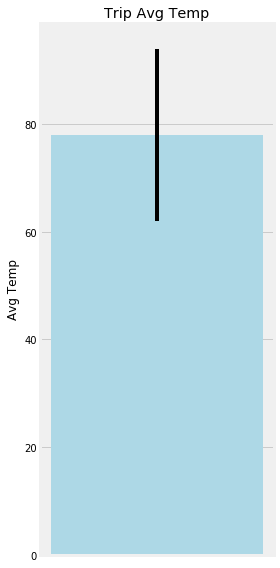

In [48]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, color='lightblue', align="center")
ax.set(xticks=range(xpos), title="Trip Avg Temp", ylabel="Temp")

fig.tight_layout()
fig.show()

In [82]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.


Total_Rain = session.query(Measurement.station, func.sum(Measurement.prcp))\
                       .filter(Measurement.date>=prev_year_start).filter(Measurement.date<=prev_year_end)\
                       .group_by(Measurement.station)\
                       .order_by(func.sum(Measurement.prcp).desc())\
                       .all()  
Total_Rain
for each in Total_Rain: print(each[0],"\t",each[1])   
    
    
    

USC00513117 	 5.7299999999999995
USC00519281 	 5.390000000000001
USC00516128 	 3.5
USC00517948 	 2.98
USC00519397 	 2.7399999999999998
USC00519523 	 2.32
USC00514830 	 1.75


In [84]:
#Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


sel = [Measurement.Station,Station.name,func.sum(Measurement.prcp),Station.latitude,station.longitude,station.elevation]
Total_Rain = Session.query(*sel).filter(Measurement.Station==Station.station)\
                       .filter(Measurement.date>=Previous_Trip_start_date)\
                       .filter(Measurement.date<=Previous_Trip_end_date)\
                       .group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc())\
                       .all()

# print("Station\t\tStation_Name\t\tRainfall\tLatitude\tLongitude\tTemperature")
# for result in Results: print(result[0],"\t",result[1],"\t",result[2],"\t\t",result[3],"\t",result[4],"\t",result[5])

for result in Results: print(Total_Rain)

AttributeError: type object 'measurement' has no attribute 'Station'

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [89]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# set the trip variables of arrive and leave for prior year
lst_year_arrive = prev_year_start - last_year
lst_year_leave = prev_year_end - last_year
last_year = dt.timedelta(days=365)
print(lst_year_arrive)
print(lst_year_leave)


# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


TypeError: unsupported operand type(s) for -: 'str' and 'datetime.date'

In [88]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= prev_year_start).\
    filter(Measurement.date <= prev_year_end).\
    order_by(Measurement.station).all()

vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station

,prcp
station,
USC00513117,5.73
USC00514830,1.75
USC00516128,3.50
USC00517948,2.98
USC00519281,5.39
USC00519397,2.74
USC00519523,2.32


NameError: name 'p2p' is not defined

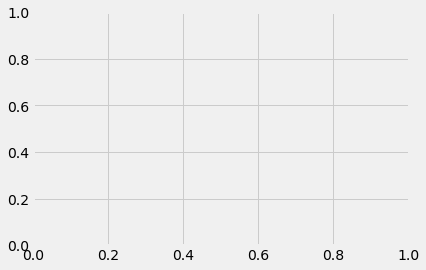

In [92]:
# Plot the daily normals as an area plot with `stacked=False`



fig, ax = plt.subplots()
bar_chart = ax.bar(1 , color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()